In [1]:
import os
import gc
import pandas as pd
import numpy as np
from datetime import datetime
from math import ceil
from tqdm import tqdm
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, accuracy_score, auc, f1_score, matthews_corrcoef, precision_score, precision_recall_curve, confusion_matrix

import tensorflow as tf
#tf.enable_eager_execution()
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, Input, GRU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from tensorflow.compat.v1.keras.layers import LSTM

seed = 8888
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

to_save = {}
to_save['random_seed'] = seed

In [2]:
def find_optimal_cutoff(TPRs, FPRs, thresholds):
    """
    Find the optimal classification threshold, where the distance between TPR and FPR is maximum
    :param TPRs: TPR values at different thresholds
    :param FPRs: FPR values at different thresholds
    :param thresholds: Different classification thresholds
    :return: optimal classification threshold, (optimal TPR, optimal FPR)
    """
    distance = TPRs - FPRs
    idx = np.argmax(distance)  # Only the first occurrence is returned.
    optimal_threshold = thresholds[idx]
    optimal_point = (TPRs[idx], FPRs[idx])
    
    return optimal_threshold, optimal_point


def roc_values(y_true, y_proba):
    """
    Get FPRs, TPRs, AUC value, optimal classification threshold, optimal TPR and optimal FPR of ROC curve
    :param y_true: True values list of sample labels
    :param y_proba: Model-predicted probability of AKI
    :return: FPRs, TPRs, AUC value, optimal classification threshold, (optimal TPR, optimal FPR)
    """
    fprs, tprs, thresholds = roc_curve(y_true, y_proba, pos_label=1)
    roc_auc = auc(fprs, tprs)
    optimal_threshold, optimal_point = find_optimal_cutoff(TPRs=tprs, FPRs=fprs, thresholds=thresholds)
    
    return fprs, tprs, roc_auc, optimal_threshold, optimal_point


def get_set(id_list, id_col, time_col, data):
    """
    Get patient data for the specified ID list
    :param id_col: Name of ID column
    :param time_col: Name of timestamp column
    :param data: DataFrame of patient data
    :return: Patient data for the specified ID list
    """
    data = data[data[id_col].isin(id_list)].sort_values(by=[id_col, time_col], ascending=True)
    data.reset_index(drop=True, inplace=True)
    
    return data


def performance(label, proba, pred):
    """
    Get model evaluation metrics
    :param label: True values list of sample labels
    :param proba: Model-predicted probability of AKI
    :param pred: Predicted values under the optimal classification threshold
    :return: Accuracy, Recall, MCC, Precision, F1-score, AUC, FPR
    """
    acc = accuracy_score(label, pred)
    recall = recall_score(label, pred, pos_label=1)
    mcc = matthews_corrcoef(label, pred)
    precision = precision_score(label, pred)
    f1 = f1_score(label, pred)
    roc_auc = roc_auc_score(label, proba)
    tn, fp, fn, tp = confusion_matrix(label, pred).ravel()
    fpr = fp/(fp+tn)
    
    print(f'accuracy: {acc:.4f}')
    print(f'recall: {recall:.4f}')
    print(f'AUC: {roc_auc:.4f}')
    print(f'MCC: {mcc:.4f}')
    print(f'precision: {precision:.4f}')
    print(f'F1: {f1:.4f}')
    print(f'FPR: {fpr:.4f}')
    
    return acc, recall, mcc, precision, f1, roc_auc, fpr

In [3]:
BATCH_SIZE = 16
EPOCHS = 5

# Imputing(feature and label)
FILL_WITH_ZERO = True
FILL_VALUE = 0

LABEL_COLUMN = 'aki_stage'
# Resample interval
RSMP = 6
# Advance prediction time
SFT = 48
# FEATURE_SET = 'SCr_lab_vit_dem_med_pro'

DATA_PATH = f'./data_con.tsv'
MODEL_SAVE_PATH = './DC-AKI_MIMIC.h5'
TEST_RESULT_PATH = f'./predict_result/DC-AKI_MIMIC_continuous.csv'
TRAINING_PARAM_PATH = './result.xls'

to_save['batch_size'] = BATCH_SIZE
to_save['epoch'] = EPOCHS
to_save['imputation'] = 'fill with zero'
to_save['resample_interval'] = RSMP
to_save['prediction_ahead'] = SFT
to_save['data_dev_path'] = DATA_PATH
to_save['model_path'] = MODEL_SAVE_PATH
to_save['test_result_path'] = TEST_RESULT_PATH

In [4]:
data_ori = pd.read_csv(DATA_PATH, sep='\t')
if 'patient_id' in data_ori.columns:
    data_ori.rename(columns={'patient_id': 'stay_id', '检验日期': 'charttime'}, inplace=True)
id_col, time_col = 'stay_id', 'charttime'
print(f'Sample num: {data_ori.stay_id.nunique()}')
data_ori.shape

Sample num: 25691


(533208, 53)

In [5]:
data_ori.head()

,charttime,stay_id,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,aniongap,...,race_UNKNOWN,race_WHITE,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT
0,2194-04-29 00:00:00,30000646,94.666667,102.200000,62.400000,71.400000,25.666667,37.111111,96.000000,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2194-04-29 06:00:00,30000646,89.880000,92.227273,51.380952,59.952381,29.826087,37.722222,96.375000,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2194-04-29 12:00:00,30000646,72.500000,94.500000,60.333333,68.166667,18.833333,36.833333,98.666667,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2194-04-29 18:00:00,30000646,83.888889,91.235294,56.294118,64.000000,22.944444,37.000000,94.500000,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2194-04-30 00:00:00,30000646,79.125000,84.125000,52.875000,60.000000,16.250000,36.583333,96.000000,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6]:
data_ori.columns

Index(['charttime', 'stay_id', 'heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'aniongap', 'bicarbonate', 'chloride',
       'hematocrit', 'hemoglobin', 'platelet', 'potassium', 'ptt', 'inr', 'pt',
       'sodium', 'bun', 'wbc', 'glucose', 'creatinine', 'uo_rt_6hr',
       'uo_rt_12hr', 'uo_rt_24hr', 'aki_stage', 'ventilation', 'vasopressor',
       'rrt', 'sedative', 'admission_age', 'gender_F', 'gender_M',
       'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN', 'race_BLACK',
       'race_HISPANIC/LATINO', 'race_MULTIPLE RACE/ETHNICITY',
       'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_PORTUGUESE',
       'race_SOUTH AMERICAN', 'race_UNKNOWN', 'race_WHITE',
       'admission_type_DIRECT EMER.', 'admission_type_DIRECT OBSERVATION',
       'admission_type_ELECTIVE', 'admission_type_EU OBSERVATION',
       'admission_type_EW EMER.', 'admission_type_OBSERVATION ADMIT',
       'admission_type_SURGICAL SAME DAY ADMISSION', 'admission_type_URGEN

In [7]:
data_ori = data_ori.rename(columns={'akistage': 'aki_stage'})

In [8]:
others = [id_col, time_col, LABEL_COLUMN]

In [9]:
data = data_ori.copy()
# Label imputing
data[LABEL_COLUMN].fillna(FILL_VALUE, inplace=True)
data[LABEL_COLUMN] = data.groupby(id_col)[LABEL_COLUMN].shift(-(SFT/RSMP))
data.dropna(subset=[LABEL_COLUMN], how='all', inplace=True)
data[LABEL_COLUMN].replace([2, 3], [1, 1], inplace=True)
    
print(f'Sample_num: {data[id_col].nunique()}')
print(f'AKI_label: {data[LABEL_COLUMN].unique()}')
data.shape

Sample_num: 25691
AKI_label: [0. 1.]


(327680, 53)

In [10]:
aki = data[[id_col, LABEL_COLUMN]].copy()
aki = aki.groupby([id_col]).max()
c = Counter(aki[LABEL_COLUMN].values)
print(f'标签数量统计: {c}')
print(f'AKI病人占比: {c[1]/len(aki):.4f}')
to_save['AKI_ratio'] = c[1]/len(aki)

标签数量统计: Counter({1.0: 16391, 0.0: 9300})
AKI病人占比: 0.6380


In [11]:
#data.charttime = pd.to_datetime(data.charttime)
data.sort_values(by=[id_col, time_col], ascending=True, inplace=True)
data.reset_index(drop=True, inplace=True)

In [12]:
new_column_order = [col for col in data.columns if col != 'aki_stage'] + ['aki_stage']
data = data[new_column_order]

In [13]:
column_order = data.columns.tolist()
print(column_order)

['charttime', 'stay_id', 'heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2', 'aniongap', 'bicarbonate', 'chloride', 'hematocrit', 'hemoglobin', 'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc', 'glucose', 'creatinine', 'uo_rt_6hr', 'uo_rt_12hr', 'uo_rt_24hr', 'ventilation', 'vasopressor', 'rrt', 'sedative', 'admission_age', 'gender_F', 'gender_M', 'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN', 'race_BLACK', 'race_HISPANIC/LATINO', 'race_MULTIPLE RACE/ETHNICITY', 'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_PORTUGUESE', 'race_SOUTH AMERICAN', 'race_UNKNOWN', 'race_WHITE', 'admission_type_DIRECT EMER.', 'admission_type_DIRECT OBSERVATION', 'admission_type_ELECTIVE', 'admission_type_EU OBSERVATION', 'admission_type_EW EMER.', 'admission_type_OBSERVATION ADMIT', 'admission_type_SURGICAL SAME DAY ADMISSION', 'admission_type_URGENT', 'aki_stage']


In [14]:
icustays = data.stay_id.unique().tolist()
features = data.columns.difference(others).tolist()

print(f'Sample num: {len(icustays)}, Feature num: {len(features)}\n')
print(f'features: {features}')

to_save['sample_num'] = len(icustays)
to_save['feature_num'] = len(features)

Sample num: 25691, Feature num: 50

features: ['admission_age', 'admission_type_DIRECT EMER.', 'admission_type_DIRECT OBSERVATION', 'admission_type_ELECTIVE', 'admission_type_EU OBSERVATION', 'admission_type_EW EMER.', 'admission_type_OBSERVATION ADMIT', 'admission_type_SURGICAL SAME DAY ADMISSION', 'admission_type_URGENT', 'aniongap', 'bicarbonate', 'bun', 'chloride', 'creatinine', 'diasbp', 'gender_F', 'gender_M', 'glucose', 'heartrate', 'hematocrit', 'hemoglobin', 'inr', 'meanbp', 'platelet', 'potassium', 'pt', 'ptt', 'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN', 'race_BLACK', 'race_HISPANIC/LATINO', 'race_MULTIPLE RACE/ETHNICITY', 'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_PORTUGUESE', 'race_SOUTH AMERICAN', 'race_UNKNOWN', 'race_WHITE', 'resprate', 'rrt', 'sedative', 'sodium', 'spo2', 'sysbp', 'tempc', 'uo_rt_12hr', 'uo_rt_24hr', 'uo_rt_6hr', 'vasopressor', 'ventilation', 'wbc']


In [15]:
data.columns

Index(['charttime', 'stay_id', 'heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'aniongap', 'bicarbonate', 'chloride',
       'hematocrit', 'hemoglobin', 'platelet', 'potassium', 'ptt', 'inr', 'pt',
       'sodium', 'bun', 'wbc', 'glucose', 'creatinine', 'uo_rt_6hr',
       'uo_rt_12hr', 'uo_rt_24hr', 'ventilation', 'vasopressor', 'rrt',
       'sedative', 'admission_age', 'gender_F', 'gender_M',
       'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN', 'race_BLACK',
       'race_HISPANIC/LATINO', 'race_MULTIPLE RACE/ETHNICITY',
       'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_PORTUGUESE',
       'race_SOUTH AMERICAN', 'race_UNKNOWN', 'race_WHITE',
       'admission_type_DIRECT EMER.', 'admission_type_DIRECT OBSERVATION',
       'admission_type_ELECTIVE', 'admission_type_EU OBSERVATION',
       'admission_type_EW EMER.', 'admission_type_OBSERVATION ADMIT',
       'admission_type_SURGICAL SAME DAY ADMISSION', 'admission_type_URGENT',
       'a

In [16]:
data.head()

,charttime,stay_id,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,aniongap,...,race_WHITE,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,admission_type_OBSERVATION ADMIT,admission_type_SURGICAL SAME DAY ADMISSION,admission_type_URGENT,aki_stage
0,2194-04-29 00:00:00,30000646,94.666667,102.200000,62.400000,71.400000,25.666667,37.111111,96.000000,12.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2194-04-29 06:00:00,30000646,89.880000,92.227273,51.380952,59.952381,29.826087,37.722222,96.375000,12.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2194-04-29 12:00:00,30000646,72.500000,94.500000,60.333333,68.166667,18.833333,36.833333,98.666667,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2194-04-29 18:00:00,30000646,83.888889,91.235294,56.294118,64.000000,22.944444,37.000000,94.500000,13.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2194-04-30 00:00:00,30000646,79.125000,84.125000,52.875000,60.000000,16.250000,36.583333,96.000000,10.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Imputing

In [17]:
print('Imputing with zero!')
data.fillna(FILL_VALUE, inplace=True)

Imputing with zero!


# Train/Validation/Test set

In [18]:
train_id, val_test_id = train_test_split(icustays, test_size=0.2, random_state=seed)
val_id, test_id = train_test_split(val_test_id, test_size=0.5, random_state=seed)
print(f'Train samples: {len(train_id)}\nValidation samples: {len(val_id)}\nTest samples: {len(test_id)}')

Train samples: 20552
Validation samples: 2569
Test samples: 2570


In [19]:
train = get_set(id_list=train_id, id_col=id_col, time_col=time_col, data=data)
val = get_set(val_id, id_col, time_col, data)
test = get_set(test_id, id_col, time_col, data)

train.shape, val.shape, test.shape

((261879, 53), (32781, 53), (33020, 53))

In [20]:
# 各集合中AKI病人占比
aki_train = train[[id_col, LABEL_COLUMN]].copy().groupby([id_col]).max()
aki_val = val[[id_col, LABEL_COLUMN]].copy().groupby([id_col]).max()
aki_test = test[[id_col, LABEL_COLUMN]].copy().groupby([id_col]).max()

print(f'train: {aki_train.aki_stage.sum()/len(aki_train):.4f}')
print(f'val: {aki_val.aki_stage.sum()/len(aki_val):.4f}')      
print(f'test: {aki_test.aki_stage.sum()/len(aki_test):.4f}')

train: 0.6374
val: 0.6357
test: 0.6455


# Split features and label / Normalization

In [21]:
train.sort_values(by=[id_col, time_col], ascending=True, inplace=True)
val.sort_values(by=[id_col, time_col], ascending=True, inplace=True)
test.sort_values(by=[id_col, time_col], ascending=True, inplace=True)

In [22]:
train = train[others+features].copy()
val = val[others+features].copy()
test = test[others+features].copy()

In [23]:
train_list = [train[train[id_col]==i].iloc[:, 2:].values for i in train_id]
val_list = [val[val[id_col]==i].iloc[:, 2:].values for i in val_id]
test_list = [test[test[id_col]==i].iloc[:, 2:].values for i in test_id]

In [24]:
# 将训练集中最长的时间序列长度设置为模型最长时间步
maxlen = train.groupby('stay_id').size().max()
to_save['time_seq_length'] = maxlen
maxlen

116

In [25]:
train_data = pad_sequences(
    train_list, 
    dtype='float32', 
    padding='pre', 
    truncating='pre', 
    value=0, 
    maxlen=maxlen
)
val_data = pad_sequences(
    val_list, 
    dtype='float32', 
    padding='pre', 
    truncating='pre', 
    value=0, 
    maxlen=maxlen
)
test_data = pad_sequences(
    test_list, 
    dtype='float32', 
    padding='pre', 
    truncating='pre', 
    value=0, 
    maxlen=maxlen
)
train_data.shape, val_data.shape, test_data.shape

((20552, 116, 51), (2569, 116, 51), (2570, 116, 51))

In [26]:
# 将特征和标签分离
train_label = train_data[:, :, 0]
val_label = val_data[:, :, 0]
test_label = test_data[:, :, 0]

train_data = train_data[:, :, 1:]
val_data = val_data[:, :, 1:]
test_data = test_data[:, :, 1:]

In [27]:
# feature normalization
train_data = train_data.reshape(-1, len(features))
val_data = val_data.reshape(-1, len(features))
test_data = test_data.reshape(-1, len(features))

feature_scaler = StandardScaler()
feature_scaler.fit(train_data)

train_data = feature_scaler.transform(train_data)
train_data = train_data.reshape(-1, maxlen, len(features))

val_data = feature_scaler.transform(val_data)
val_data = val_data.reshape(-1, maxlen, len(features))

test_data = feature_scaler.transform(test_data)
test_data = test_data.reshape(-1, maxlen, len(features))

train_data.shape, val_data.shape, test_data.shape

((20552, 116, 50), (2569, 116, 50), (2570, 116, 50))

In [28]:
# label one-hot
train_label = train_label.reshape(-1, maxlen, 1)
val_label = val_label.reshape(-1, maxlen, 1)
test_label = test_label.reshape(-1, maxlen, 1)

train_label = to_categorical(train_label)
val_label = to_categorical(val_label)
test_label = to_categorical(test_label)

train_label.shape, val_label.shape, test_label.shape

((20552, 116, 2), (2569, 116, 2), (2570, 116, 2))

# DC-AKI(base)

In [29]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Bidirectional, Dense, Dropout, Attention
def get_model(max_len, feature_num):
    
    clear_session()
    inputs = Input(shape=(max_len, feature_num), dtype='float32')
    x = Dense(32, activation='relu')(inputs)
    outputs = Dense(2, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.summary()
    
    return model

In [30]:
model = get_model(max_len=maxlen, feature_num=len(features))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 116, 50)]         0         
_________________________________________________________________
dense (Dense)                (None, 116, 32)           1632      
_________________________________________________________________
dense_1 (Dense)              (None, 116, 2)            66        
Total params: 1,698
Trainable params: 1,698
Non-trainable params: 0
_________________________________________________________________


In [31]:
adam = optimizers.Adam(lr=0.001)
loss = BinaryCrossentropy(from_logits=False)
k_auc = AUC()

checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH, 
    monitor='val_auc', 
    mode='max', 
    save_best_only=True
)

model.compile(
    optimizer=adam, 
    loss=loss,
    metrics=[k_auc]
)

to_save['lr'] = 0.001

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
time_start = datetime.now()
history = model.fit(
    train_data, train_label,
    validation_data=(val_data, val_label), 
    batch_size=2048, 
    epochs=1, 
    callbacks=[checkpoint])
train_time = (datetime.now() - time_start).total_seconds()
to_save['train_time'] = train_time
print(train_time)

Train on 20552 samples, validate on 2569 samples
20552/20552 [==============================] - 8s 383us/sample - loss: 0.6679 - auc: 0.8927 - val_loss: 0.5926 - val_auc: 0.9098
8.300179


In [33]:
test_BASE = model.predict(test_data)
from sklearn.metrics import roc_auc_score

# 将三维数组转换为一维数组
reshaped_test_BASE = test_BASE.flatten()
reshaped_true_label = test_label.flatten()

# 计算 ROC AUC
roc_auc = roc_auc_score(reshaped_true_label, reshaped_test_BASE)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.9077549808859434


In [34]:
from sklearn.metrics import precision_recall_curve, auc,f1_score
precision_BASE, recall_BASE, thresholds = precision_recall_curve(reshaped_true_label, reshaped_test_BASE)
# 计算 PR AUC
pr_auc_BASE = auc(recall_BASE, precision_BASE)


print("PR AUC:", pr_auc_BASE)
threshold = 0.5
reshaped_test_BASE = (reshaped_test_BASE > threshold).astype(int)
f1 = f1_score(reshaped_true_label, reshaped_test_BASE)
print(f1)

PR AUC: 0.695365899076885
0.9427717129086274


In [35]:
test_result.to_csv(TEST_RESULT_PATH, index=False)

# DC-AKI

In [65]:
from tensorflow.keras.layers import Input, Flatten, Conv1D, MaxPooling1D, GRU, Bidirectional, Dense, Dropout, Concatenate, Activation, GlobalMaxPooling1D, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape
def get_model(max_len, feature_num):
    x = Input(shape=(max_len, feature_num), dtype='float32')
    x1 = Dense(32, activation='relu')(x)
    x1 = GRU(32, return_sequences=True)(x1)
    x1 = Dropout(0.5)(x1)
    x1 = GRU(32, return_sequences=True)(x1)
    x1 = Dropout(0.5)(x1)
    attention = Dense(32, activation='tanh')(x1)
    attention = Flatten()(attention)
    attention = Activation('sigmoid')(attention)
    attention_reshaped = Reshape((max_len, 32))(attention)
    
    # Multiply and Add layers for element-wise multiplication and addition
    attention_mult = Multiply()([x1, attention_reshaped])
    attention_sum = Add()([x1, attention_reshaped])
    
    y2 = Dense(32, activation='relu')(x)
    y2 = Conv1D(filters=128, kernel_size=3, padding='same')(y2)
    y2 = Dropout(0.5)(y2)
    #y2 = GlobalMaxPooling1D()(y2)
    y2 = Dense(64, activation='relu')(y2)
    concatenated = Concatenate()([attention_mult, attention_sum, y2])
    concatenated = Dense(32, activation='relu')(concatenated)
    outputs = Dense(2, activation='sigmoid')(concatenated)
    
    model = Model(inputs=x, outputs=outputs)
    model.summary()
    
    return model


In [66]:
model_our = get_model(max_len=maxlen, feature_num=len(features))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 50)]    0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 116, 32)      1632        input_2[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 116, 32)      6240        dense_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 116, 32)      0           gru_1[0][0]                      
____________________________________________________________________________________________

In [67]:
adam = optimizers.Adam(lr=0.001)
loss = BinaryCrossentropy(from_logits=False)
k_auc = AUC()

checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH, 
    monitor='val_auc', 
    mode='max', 
    save_best_only=True
)

model_our.compile(
    optimizer=adam, 
    loss=loss,
    metrics=[k_auc]
)

to_save['lr'] = 0.001

In [68]:
time_start = datetime.now()
history = model_our.fit(
    train_data, train_label,
    validation_data=(val_data, val_label), 
    batch_size=2048, 
    epochs=1, 
    callbacks=[checkpoint])
train_time = (datetime.now() - time_start).total_seconds()
to_save['train_time'] = train_time
print(train_time)

Train on 20552 samples, validate on 2569 samples
20480/20552 [============================>.] - ETA: 0s - loss: 0.4473 - auc_1: 0.9565WARNING:tensorflow:Can save best model only with val_auc available, skipping.


20552/20552 [==============================] - 77s 4ms/sample - loss: 0.4466 - auc_1: 0.9566 - val_loss: 0.2029 - val_auc_1: 0.9943
79.530539


In [ ]:
from sklearn.model_selection import train_test_split, GroupKFold, KFold
from tensorflow import keras
from tqdm import tqdm

COMPUTE_LSTM_IMPORTANCE = 1
ONE_FOLD_ONLY = 1
NUM_FOLDS = 28
COLS = (['heartrate', 'sysbp', 'diasbp', 'meanbp',
       'resprate', 'tempc', 'spo2', 'aniongap', 'bicarbonate', 'chloride',
       'hematocrit', 'hemoglobin', 'platelet', 'potassium', 'ptt', 'inr', 'pt',
       'sodium', 'bun', 'wbc', 'glucose', 'creatinine', 'uo_rt_6hr',
       'uo_rt_12hr', 'uo_rt_24hr', 'ventilation', 'vasopressor', 'rrt',
       'sedative', 'admission_age', 'gender_F', 'gender_M',
       'race_AMERICAN INDIAN/ALASKA NATIVE', 'race_ASIAN', 'race_BLACK',
       'race_HISPANIC/LATINO', 'race_MULTIPLE RACE/ETHNICITY',
       'race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'race_PORTUGUESE',
       'race_SOUTH AMERICAN', 'race_UNKNOWN', 'race_WHITE',
       'admission_type_DIRECT EMER.', 'admission_type_DIRECT OBSERVATION',
       'admission_type_ELECTIVE', 'admission_type_EU OBSERVATION',
       'admission_type_EW EMER.', 'admission_type_OBSERVATION ADMIT',
       'admission_type_SURGICAL SAME DAY ADMISSION', 'admission_type_URGENT',
       'aki_stage'])

import matplotlib.pyplot as plt
model = keras.models.load_model('./DC-AKI.h5')
        # 计算特征重要性
if COMPUTE_LSTM_IMPORTANCE:
            results = []
            print(' Computing GRU feature importance...')
            

            for k in tqdm(range(50)):
                save_col = train_data[:,:,k].copy()
                np.random.shuffle(train_data[:,:,k])
                oof_preds = model.predict(train_data, verbose=0).squeeze() 
                mae = np.mean(np.abs( oof_preds-train_label))
                results.append({'feature':COLS[k],'mae':mae})
                train_data[:,:,k] = save_col
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('mae')
            plt.figure(figsize=(10,10))
            plt.barh(np.arange(len(COLS)+1),df.mae)
            plt.yticks(np.arange(len(COLS)+1),df.feature.values)
            plt.title('GRU Feature Importance',size=12)
            plt.ylim((-1,len(COLS)+1))
            plt.xlim((0.15, max(df.mae) + 0.1))  # 添加这行代码
            plt.show()
                               
            # SAVE LSTM FEATURE IMPORTANCE
            df = df.sort_values('mae',ascending=False)
            df.to_csv(f'feature_importance_fold12_48.csv',index=False)
                               
        # ONLY DO ONE FOLD
#if ONE_FOLD_ONLY: break

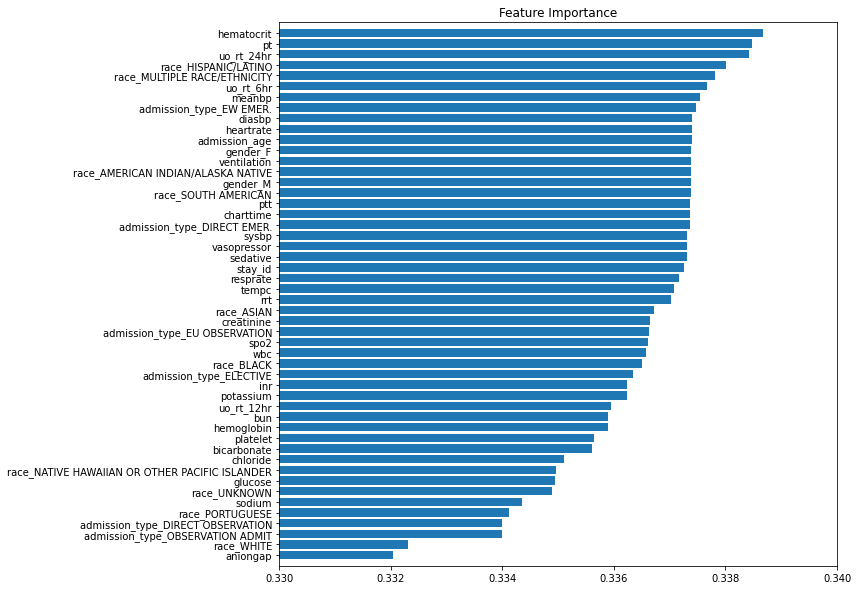

In [77]:
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('mae')
            plt.figure(figsize=(10,10))
            plt.barh(np.arange(50),df.mae)
            plt.yticks(np.arange(50),df.feature.values)
            plt.title('Feature Importance',size=12)
            plt.ylim((-1,50))
            plt.xlim((0.3300, 0.3400))  # 添加这行代码
            plt.show()
                               
            # SAVE LSTM FEATURE IMPORTANCE
            df = df.sort_values('mae',ascending=False)
            df.to_csv(f'GRU_feature_importance_fold12_48.csv',index=False)
                               

In [69]:
test_our = model_our.predict(test_data)
from sklearn.metrics import roc_auc_score

# 将三维数组转换为一维数组
reshaped_test_our = test_our.flatten()
reshaped_true_label = test_label.flatten()

# 计算 ROC AUC
roc_auc_our = roc_auc_score(reshaped_true_label, reshaped_test_our)
print(f"ROC AUC: {roc_auc_our}")

ROC AUC: 0.9939618332354015


In [40]:
fpr_our, tpr_our, thresholds_our = roc_curve(reshaped_true_label, reshaped_test_our)
roc_auc_our = auc(fpr_our, tpr_our)
print(roc_auc_our)

0.9946422857064701


In [41]:
roc_auc_our = roc_auc_score(reshaped_true_label, reshaped_test_our)
print(f"ROC AUC: {roc_auc_our}")

ROC AUC: 0.9946422857064701


In [42]:
from sklearn.metrics import precision_recall_curve, auc,f1_score
precision_our, recall_our, thresholds = precision_recall_curve(reshaped_true_label, reshaped_test_our)
# 计算 PR AUC
pr_auc_our= auc(recall_our, precision_our)
print("PR AUC:", pr_auc_our)
threshold = 0.5
reshaped_test_our = (reshaped_test_our > threshold).astype(int)
f1 = f1_score(reshaped_true_label, reshaped_test_our)
print(f1)

PR AUC: 0.9445639560397022
0.9642688212767749


# DC-AKI(GRU)

In [59]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Bidirectional, Dense, Dropout, Attention
def get_model(max_len, feature_num):
    
    clear_session()
    inputs = Input(shape=(max_len, feature_num), dtype='float32')
    x1 = Dense(32, activation='relu')(inputs)
    x1 = GRU(64, return_sequences=True)(x1)
    x1 = Dropout(0.5)(x1)
    attention = Dense(64, activation='tanh')(x1)
    attention = Flatten()(attention)
    attention = Activation('sigmoid')(attention)
    attention_reshaped = Reshape((max_len, 64))(attention)
    attention_mult = Multiply()([x1, attention_reshaped])
    attention_sum = Add()([x1, attention_reshaped])
    outputs = Dense(2, activation='sigmoid')(attention_sum)

    model = Model(inputs, outputs)
    model.summary()
    
    return model

In [60]:
model_GRU = get_model(max_len=maxlen, feature_num=len(features))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 50)]    0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 116, 32)      1632        input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 116, 64)      18624       dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 116, 64)      0           gru[0][0]                        
______________________________________________________________________________________________

In [61]:
adam = optimizers.Adam(lr=0.001)
loss = BinaryCrossentropy(from_logits=False)
k_auc = AUC()

checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH, 
    monitor='val_auc', 
    mode='max', 
    save_best_only=True
)

model_GRU.compile(
    optimizer=adam, 
    loss=loss,
    metrics=[k_auc]
)

to_save['lr'] = 0.001

In [62]:
time_start = datetime.now()
history = model_GRU.fit(
    train_data, train_label,
    validation_data=(val_data, val_label), 
    batch_size=2048, 
    epochs=1, 
    callbacks=[checkpoint])
train_time = (datetime.now() - time_start).total_seconds()
to_save['train_time'] = train_time
print(train_time)

Train on 20552 samples, validate on 2569 samples
20552/20552 [==============================] - 28s 1ms/sample - loss: 0.7008 - auc: 0.5767 - val_loss: 0.4433 - val_auc: 0.9432
29.027637


In [63]:
test_GRU = model_GRU.predict(test_data)
from sklearn.metrics import roc_auc_score

# 将三维数组转换为一维数组
reshaped_test_GRU = test_GRU.flatten()
#reshaped_true_label = true_label.flatten()

# 计算 ROC AUC
roc_auc_GRU = roc_auc_score(reshaped_true_label, reshaped_test_GRU)
print(f"ROC AUC: {roc_auc_GRU}")

ROC AUC: 0.9420460409968572


In [64]:
from sklearn.metrics import precision_recall_curve, auc,f1_score
precision_GRU, recall_GRU, thresholds = precision_recall_curve(reshaped_true_label, reshaped_test_GRU)
# 计算 PR AUC
pr_auc_GRU = auc(recall_GRU, precision_GRU)
print("PR AUC:", pr_auc_GRU)
threshold = 0.5
reshaped_test_GRU = (reshaped_test_GRU > threshold).astype(int)
f1 = f1_score(reshaped_true_label, reshaped_test_GRU)
print(f1)

PR AUC: 0.8732542732634184
0.9602261051766362


# DA-AKI(CNN)

In [53]:
from tensorflow.keras.layers import Input,Flatten, Conv1D, MaxPooling1D, GRU, Bidirectional, Dense, Dropout, Concatenate, Activation, Dot,GlobalMaxPooling1D,SimpleRNN

def get_model(max_len, feature_num):
    x = Input(shape=(max_len, feature_num), dtype='float32')
    y2 = Conv1D(filters=32, kernel_size=3, padding='same')(x)
    y2 = Dropout(0.5)(y2)
   # y2 = Dense(64, activation='relu')(y2)
    outputs = Dense(2, activation='sigmoid')(y2)
    
    model = Model(inputs=x, outputs=outputs)
    model.summary()
    
    return model

In [54]:
model_CNN = get_model(max_len=maxlen, feature_num=len(features))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 116, 50)]         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 32)           4832      
_________________________________________________________________
dropout_2 (Dropout)          (None, 116, 32)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 116, 2)            66        
Total params: 4,898
Trainable params: 4,898
Non-trainable params: 0
_________________________________________________________________


In [55]:
adam = optimizers.Adam(lr=0.001)
loss = BinaryCrossentropy(from_logits=False)
k_auc = AUC()

checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH, 
    monitor='val_auc', 
    mode='max', 
    save_best_only=True
)

model_CNN.compile(
    optimizer=adam, 
    loss=loss,
    metrics=[k_auc]
)

to_save['lr'] = 0.001

In [56]:
time_start = datetime.now()
history = model_CNN.fit(
    train_data, train_label,
    validation_data=(val_data, val_label), 
    batch_size=2048, 
    epochs=1, 
    callbacks=[checkpoint])
train_time = (datetime.now() - time_start).total_seconds()
to_save['train_time'] = train_time
print(train_time)

Train on 20552 samples, validate on 2569 samples
20480/20552 [============================>.] - ETA: 0s - loss: 0.8400 - auc_2: 0.6382WARNING:tensorflow:Can save best model only with val_auc available, skipping.


20552/20552 [==============================] - 11s 546us/sample - loss: 0.8398 - auc_2: 0.6395 - val_loss: 0.7165 - val_auc_2: 0.8539
11.845462


In [57]:
test_CNN = model_CNN.predict(test_data)
from sklearn.metrics import roc_auc_score

# 将三维数组转换为一维数组
reshaped_test_CNN = test_CNN.flatten()
reshaped_true_label = test_label.flatten()

# 计算 ROC AUC
roc_auc_CNN = roc_auc_score(reshaped_true_label, reshaped_test_CNN)
print(f"ROC AUC: {roc_auc_CNN}")

ERROR! Session/line number was not unique in database. History logging moved to new session 895
ROC AUC: 0.8549435799904455


In [58]:
from sklearn.metrics import precision_recall_curve, auc,f1_score
precision_CNN, recall_CNN, thresholds = precision_recall_curve(reshaped_true_label, reshaped_test_CNN)
# 计算 PR AUC
pr_auc_CNN= auc(recall_CNN, precision_CNN)


print("PR AUC:", pr_auc_CNN)
threshold = 0.5
reshaped_test_CNN= (reshaped_test_CNN > threshold).astype(int)
f1 = f1_score(reshaped_true_label, reshaped_test_CNN)
print(f1)

PR AUC: 0.6071533412771393
0.919239462569658
